This is a very basic implementation of figure 1 in the GAN paper

# Import

In [1]:
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from scipy.stats import truncnorm, uniform

from IPython.core.debugger import set_trace

# First, generate data

In [2]:
r = (-1, 1) # Range of data

In [3]:
def _get_samples(dist, num_samples):
    return torch.tensor(dist.rvs(num_samples), dtype=torch.float)[:, None]

In [4]:
def _get_norm(mu, std, num_samples):
    a = (r[0]-mu)/std
    b = (r[1]-mu)/std
    return _get_samples(truncnorm(a, b, mu, std), num_samples)

In [5]:
def _get_uniform(num_samples):
    a = r[0]
    b = r[1]-r[0]
    return _get_samples(uniform(a, b), num_samples)

In [6]:
def _plot_hist(y, ax=None):
    if not ax:
        ax = plt.gca()
    ax.hist(y.view(-1).detach().numpy());
    ax.set_xlim((r[0]-0.25, r[1]+0.25))

Get true samples

In [7]:
num_samples = 1000
y_T = _get_norm(0.5, 0.05, num_samples)
y_T.shape

torch.Size([1000, 1])

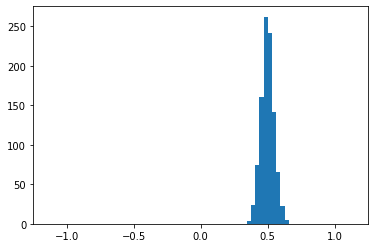

In [8]:
_plot_hist(y_T)

# Networks

Initializing bias to zero makes it zero centered initially and res blocks help stability. Tanh makes it more curvy. 

In [9]:
def init(m):
    if isinstance(m, nn.Linear):
        nn.init.zeros_(m.bias)

In [10]:
class res_block(nn.Module):
    def __init__(self, n=2):
        super(res_block, self).__init__()
        self.net = nn.Sequential(*[nn.Sequential(nn.Linear(1,1),
                                                 nn.Tanh())
                                   for _ in range(n)])
        
    def forward(self, X):
        return X + self.net(X)        

In [11]:
class res(nn.Module):
    def __init__(self, n):
        super(res, self).__init__()
        self.net = nn.Sequential(*[res_block() for _ in range(n)], 
                                 nn.Linear(1,1))
        self.net.apply(init)
        
    def forward(self, X):
        return self.net(X)        

# Train

In [12]:
def _freeze(m):
    for p in m.parameters():
        m.requires_grad = False

In [13]:
def _unfreeze(m):
    for p in m.parameters():
        m.requires_grad = True

In [14]:
def _plot_update():
    # Plot original and GAN samples
    ax1 = plt.gca()
    _plot_hist(y_T, ax1)
    _plot_hist(gen(_get_uniform(num_samples)), ax1)
    
    # Plot discriminator
    ax2 = ax1.twinx()
    X = torch.linspace(r[0], r[1], 100)[:, None]
    ax2.plot(X, torch.sigmoid(dis(X)).detach().numpy(), 'r')
    ax2.set_ylim(0, 1)

In [15]:
def _update_dis():
    # Unfreeze discriminator
    _unfreeze(dis)

    # Freeze generator
    _freeze(gen)

    # Get fakes
    z = _get_uniform(num_samples)
    y_F = gen(z).detach()

    # Append
    y = torch.cat([y_T, y_F], dim=0)

    # Get discriminator truth
    y_dis = torch.cat([torch.ones_like(y_T), torch.zeros_like(y_F)], dim=0)

    # Get discriminator outputs
    y_hat_dis = dis(y)

    # Optimize
    opt_dis.zero_grad()
    l = F.binary_cross_entropy_with_logits(y_hat_dis, y_dis)
    l.backward()
    opt_dis.step()

In [16]:
def _update_gen():
    # Unfreeze generator
    _unfreeze(gen)

    # Freeze discriminator
    _freeze(dis)

    # Get fakes
    z = _get_uniform(num_samples)
    y_F = gen(z)

    # Set values to true to fool discriminator
    y_dis = torch.ones_like(y_F)

    # Get discriminator outputs
    y_hat_dis = dis(y_F)

    # Optimize
    opt_gen.zero_grad()
    l = F.binary_cross_entropy_with_logits(y_hat_dis, y_dis)
    l.backward()
    opt_gen.step()

## Test 1 - train discriminator a lot in the beginning

In [20]:
# Initialize generator and discriminator
gen = res(3)
dis = res(3)

In [21]:
# Get optimizers
lr = 1e-2
opt_gen = optim.RMSprop(gen.parameters(), lr=lr)
opt_dis = optim.RMSprop(dis.parameters(), lr=lr)

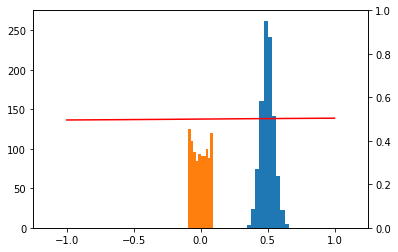

In [22]:
# Plot initial generator and discriminator
_plot_update()

Do a lot of updates for discriminator

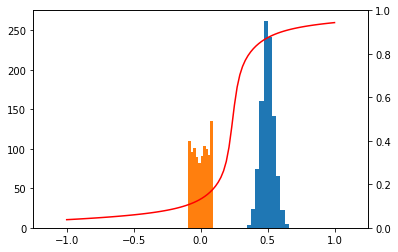

In [23]:
[_update_dis() for i in range(20)];
_plot_update()

Seems to be doing a good job at discriminating...

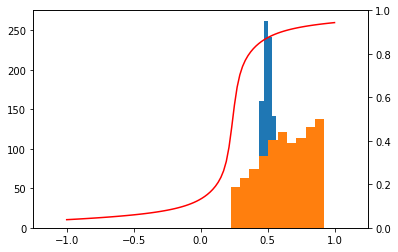

In [24]:
[_update_gen() for i in range(3)];
_plot_update()

Good updates

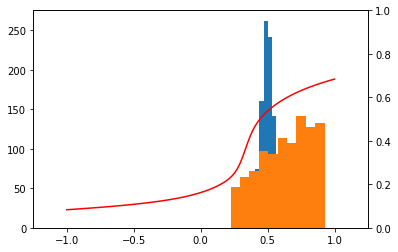

In [25]:
[_update_dis() for i in range(20)];
_plot_update()

Still hasn't updated nicely, lets see what happens if we update generator

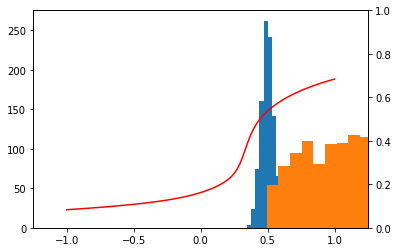

In [26]:
[_update_gen() for i in range(3)];
_plot_update()

Samples get pushed too far to the right. This is because discriminator doesnt curve down after the true samples and actually has an upward slope

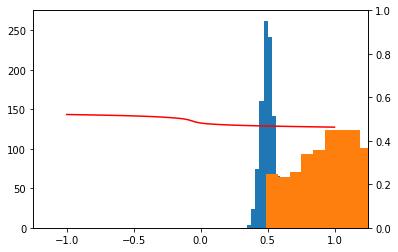

In [29]:
[_update_dis() for i in range(100)];
_plot_update()

Now there's a downward slop again, but its "forgotten" the upward slope before the samples

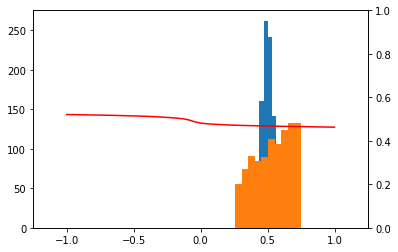

In [35]:
[_update_gen() for i in range(50)];
_plot_update()

Took a lot of iterations to push it back. I think this demostrates the difficulty of training a GAN...

## Test 2 - Take more care in updating 

In [111]:
# Initialize generator and discriminator
gen = res(3)
dis = res(3)

In [112]:
# Get optimizers
lr = 1e-2
opt_gen = optim.RMSprop(gen.parameters(), lr=lr)
opt_dis = optim.RMSprop(dis.parameters(), lr=lr)

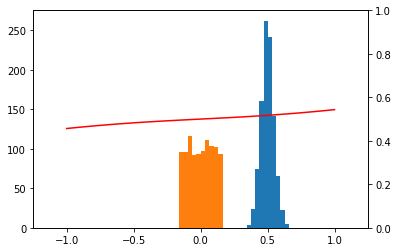

In [113]:
# Plot initial generator and discriminator
_plot_update()

Do fewer updates

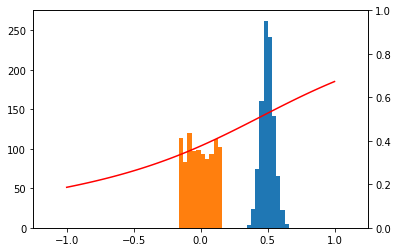

In [114]:
[_update_dis() for i in range(5)];
_plot_update()

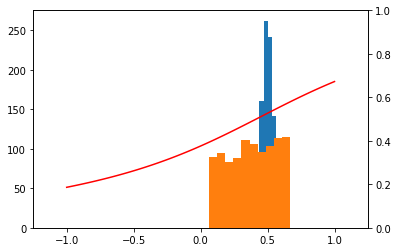

In [117]:
[_update_gen() for i in range(1)];
_plot_update()

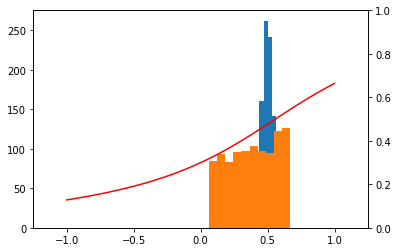

In [118]:
[_update_dis() for i in range(5)];
_plot_update()

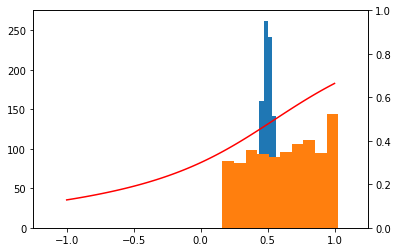

In [119]:
[_update_gen() for i in range(1)];
_plot_update()

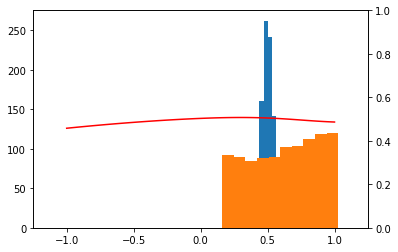

In [120]:
[_update_dis() for i in range(100)];
_plot_update()

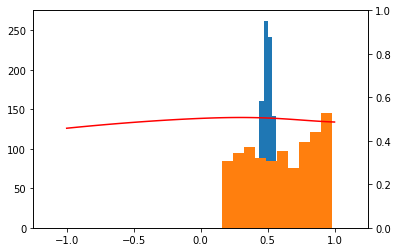

In [121]:
[_update_gen() for i in range(1)];
_plot_update()

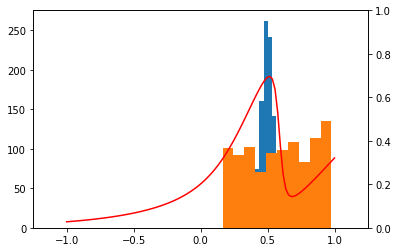

In [122]:
[_update_dis() for i in range(100)];
_plot_update()

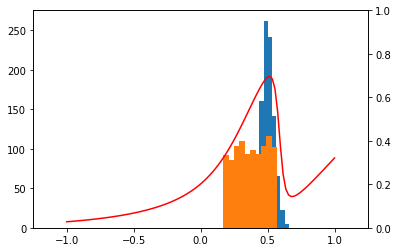

In [124]:
[_update_gen() for i in range(1)];
_plot_update()

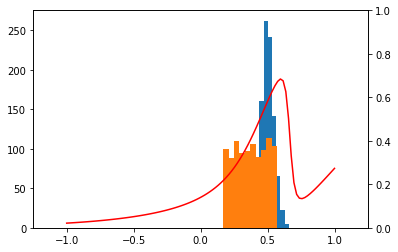

In [125]:
[_update_dis() for i in range(5)];
_plot_update()

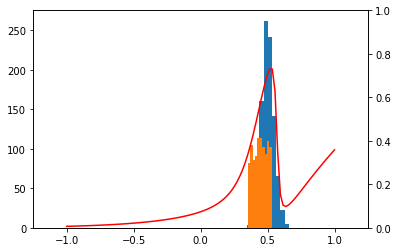

In [133]:
[_update_gen() for i in range(1)];
_plot_update()

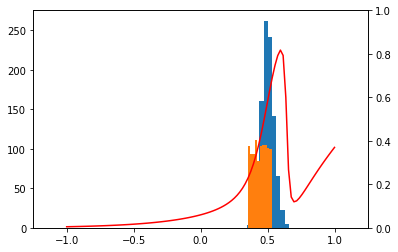

In [136]:
[_update_dis() for i in range(10)];
_plot_update()

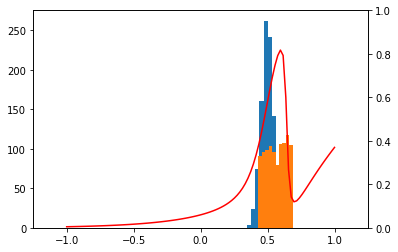

In [137]:
[_update_gen() for i in range(1)];
_plot_update()

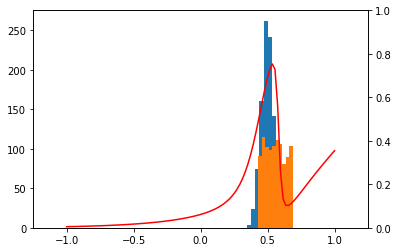

In [138]:
[_update_dis() for i in range(10)];
_plot_update()

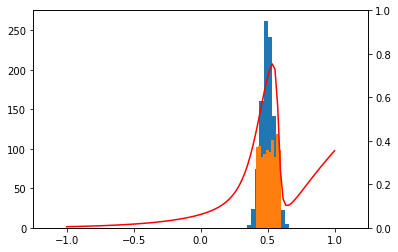

In [140]:
[_update_gen() for i in range(1)];
_plot_update()

Should the discriminator eventually settle on 1/2 for all values? In theory that would prevent the generator from updating which makes sense, but it would have to essentially "forget" everything it's learned